In [9]:
from model import SugarscapeCg
from agents import Cop, Criminal

from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner, BatchRunnerMP

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime

## Helper functions

In [10]:
def run_model(model):
    model.run_model(step_count=300)

    output = model.datacollector.get_model_vars_dataframe()
    #print(output)

    return output

In [11]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [12]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [13]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    avg_crimes_per_distr_dict = {'Centrum': 0, 'Nieuw-West': 0, 'Noord': 0, 'Oost': 0, 'West': 0, 'Zuid': 0, 'Zuidoost': 0} 
    confidence_bounds = dict()
    means_dict_for_ci = {}
    
    for i in range(len(outputs)):
        for district in district_names:
            district_mean = np.mean(outputs[i].iloc[burn_in:][district])
            avg_crimes_per_distr_dict[district] += district_mean
            if district in means_dict_for_ci.keys():
                means_dict_for_ci[district].append(district_mean)
            else:
                means_dict_for_ci[district] = [district_mean]
          
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    avg_crimes_per_distr_dict = dict(sorted(avg_crimes_per_distr_dict.items(), key=lambda item:item[1]))
    
    
    for district in avg_crimes_per_distr_dict.keys():
        confidence_bounds[district] = 1.96*np.std(means_dict_for_ci[district])/len(means_dict_for_ci[district])
    return avg_crimes_per_distr_dict, confidence_bounds

## Plotting functions

In [14]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [15]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [16]:
# def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
#     plt.bar(np.arange(len(district_means)), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
#     plt.xticks(np.arange(len(district_means)), district_names)
#     # plt.xlabel("Number of steps")
#     plt.ylabel('Number of crimes')

In [21]:
def plot_district_means_bar(avg_crimes_per_distr_dict, district_colors,confidence_bounds,filename):
    plt.bar(avg_crimes_per_distr_dict.keys(), avg_crimes_per_distr_dict.values(), yerr=confidence_bounds.values(), color=district_colors, capsize=10)
    ct = datetime.datetime.now()
    name = filename + str(ct) + '.jpeg'
    plt.savefig(name,dpi='figure')
    plt.show()
    return

In [18]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Sensitivity Analysis

In [11]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'],
    'bounds': [[0, 20], [1, 10], [1, 10], [0, 500], [0, 100]]
}

# Set the outputs
model_reporters = {
    "Total crimes": lambda m: m.schedule.get_crimes_commited(), 
    "Criminals in jail": lambda m: m.schedule.get_criminal_count_in_jail(),
    # "Centrum": lambda m: m.get_crimes_per_district()['Centrum'],
    # "Noord": lambda m: m.get_crimes_per_district()['Noord'],
    # "West": lambda m: m.get_crimes_per_district()['West'],
    # "Zuid": lambda m: m.get_crimes_per_district()['Zuid'],
    # "Zuidoost": lambda m: m.get_crimes_per_district()['Zuidoost'],
    # "Oost": lambda m: m.get_crimes_per_district()['Oost'],
    # "Nieuw-West": lambda m: m.get_crimes_per_district()['Nieuw-West'],
    "Centrum": lambda m:m.schedule.update_average_crimes_per_timestep("Centrum").get("Centrum"),
    "Noord": lambda m:m.schedule.update_average_crimes_per_timestep("Noord").get("Noord"),
    "West": lambda m:m.schedule.update_average_crimes_per_timestep("West").get("West"),
    "Zuid": lambda m:m.schedule.update_average_crimes_per_timestep("Zuid").get("Zuid"),
    "Zuidoost": lambda m:m.schedule.update_average_crimes_per_timestep("Zuidoost").get("Zuidoost"),
    "Oost": lambda m:m.schedule.update_average_crimes_per_timestep("Oost").get("Oost"),
    "Nieuw-West": lambda m:m.schedule.update_average_crimes_per_timestep("Nieuw-West").get("Nieuw-West")
}
# model_reporters = {"Data Collector": lambda m: m.datacollector},

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 1#10
max_steps = 300#200
distinct_samples = 500#500

param_values = saltelli.sample(problem, N=distinct_samples, calc_second_order=False)
# print(param_values)

param_values_rounded = [np.rint(row).astype(int) for row in param_values]
uniques = np.unique(param_values_rounded,axis=0)
print(len(uniques))
param_values = uniques
# print(uniques)

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

28


In [12]:
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'])
data['Run'], data['Centrum'], data['Criminals in jail'] = None, None, None
data['Nieuw-West'], data['Noord'], data['Oost'], data['Total crimes'], data['West'], data['Zuid'], data['Zuidoost'] = None, None, None, None, None, None, None

# print(data)

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        # vals = list(vals)
        # vals = [int(item) for item in vals]
        # print(vals)
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        # print(variable_parameters)

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = int(count) # Don't know what causes this, but iteration number is not correctly filled
        # print(iteration_data)

        data.iloc[count, :len(problem['names'])] = vals  # fills in varied parameter
        data.iloc[count, len(problem['names']):] = iteration_data  # fills in output data
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

3.57% done
7.14% done
10.71% done
14.29% done
17.86% done
21.43% done
25.00% done
28.57% done
32.14% done
35.71% done
39.29% done
42.86% done
46.43% done
50.00% done
53.57% done
57.14% done
60.71% done
64.29% done
67.86% done
71.43% done
75.00% done
78.57% done
82.14% done
85.71% done
89.29% done
92.86% done
96.43% done
100.00% done


In [13]:
print(data)

ct = datetime.datetime.now()
filename = 'sensitivity_analysis_output_' + str(ct)
data.to_csv(filename)

   jail_sentence criminal_risk_radius cop_catch_radius criminal_risk_aversion  \
0              2                    5                5                    234   
1              2                    5                5                    328   
2              2                    5                5                    328   
3              2                    5                9                    328   
4              2                    6                5                    328   
5              4                    3                3                    453   
6              4                    8                2                    359   
7              7                    4                7                    203   
8              7                    7                6                    203   
9              7                    7                7                    109   
10             7                    7                7                    203   
11             7            

In [14]:
Si_crimes = sobol.analyze(problem, data['Total crimes'].values, calc_second_order=False, print_to_console=True)
Si_jail = sobol.analyze(problem, data['Criminals in jail'].values, calc_second_order=False, print_to_console=True)
Si_centrum = sobol.analyze(problem, data['Centrum'].values, calc_second_order=False, print_to_console=True)
Si_noord = sobol.analyze(problem, data['Noord'].values, calc_second_order=False, print_to_console=True)
Si_west = sobol.analyze(problem, data['West'].values, calc_second_order=False, print_to_console=True)
Si_zuid = sobol.analyze(problem, data['Zuid'].values, calc_second_order=False, print_to_console=True)
Si_zuidoost = sobol.analyze(problem, data['Zuidoost'].values, calc_second_order=False, print_to_console=True)
Si_oost = sobol.analyze(problem, data['Oost'].values, calc_second_order=False, print_to_console=True)
Si_nieuw_west = sobol.analyze(problem, data['Nieuw-West'].values, calc_second_order=False, print_to_console=True)

                                ST   ST_conf
jail_sentence             0.440070  2.842147
criminal_risk_radius      0.148922  1.072008
cop_catch_radius          0.432662  2.327424
criminal_risk_aversion    0.984199  5.861741
criminal_disconnectivity  0.028686  0.032737
                                S1   S1_conf
jail_sentence            -0.318162  0.635453
criminal_risk_radius      0.011041  0.480557
cop_catch_radius         -0.244103  0.737756
criminal_risk_aversion   -0.637219  4.843605
criminal_disconnectivity -0.253850  0.322557
                                ST   ST_conf
jail_sentence             1.134017  1.897807
criminal_risk_radius      0.347277  0.744299
cop_catch_radius          0.709708  2.232790
criminal_risk_aversion    0.963536  3.273065
criminal_disconnectivity  0.593528  1.899407
                                S1   S1_conf
jail_sentence             0.574766  1.395835
criminal_risk_radius      0.103732  0.827366
cop_catch_radius          0.097057  1.921984
criminal_r

{'S1': array([-0.31816223,  0.01104066, -0.24410328, -0.63721885, -0.25385035]), 'S1_conf': array([0.63545305, 0.48055669, 0.73775645, 4.8436048 , 0.32255728]), 'ST': array([0.44006974, 0.14892164, 0.43266167, 0.98419912, 0.02868594]), 'ST_conf': array([2.84214724, 1.07200787, 2.3274241 , 5.86174098, 0.03273717])}


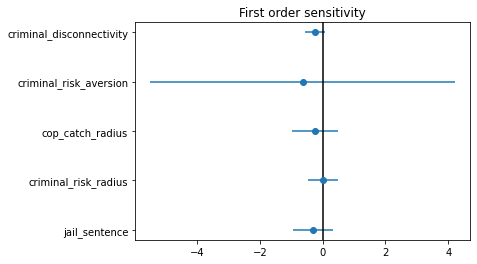

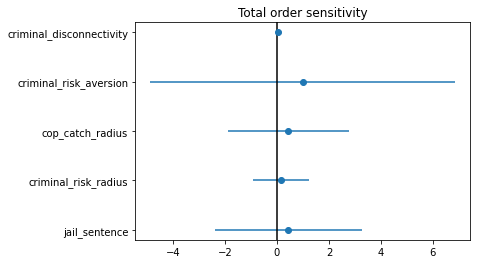

{'S1': array([ 0.57476604,  0.1037321 ,  0.09705717,  0.04888939, -0.0739655 ]), 'S1_conf': array([1.39583543, 0.82736585, 1.92198374, 2.27545252, 1.88724249]), 'ST': array([1.13401736, 0.34727703, 0.70970797, 0.96353591, 0.59352802]), 'ST_conf': array([1.89780679, 0.7442992 , 2.23279048, 3.27306458, 1.89940739])}


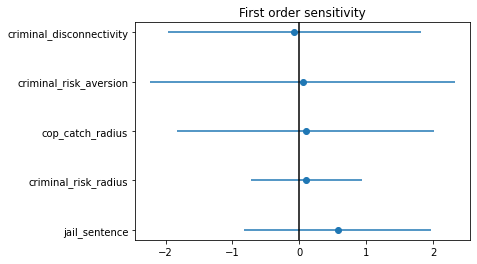

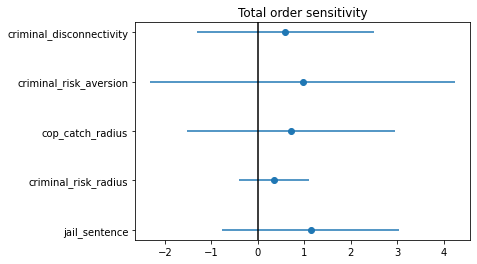

{'S1': array([ 1.14888418,  1.20602688,  1.62279583,  2.20504643, -0.6516226 ]), 'S1_conf': array([1.31450859, 0.79066753, 2.02464225, 1.07531909, 2.48457393]), 'ST': array([0.69618846, 0.56885234, 1.47061247, 1.58605106, 1.8903183 ]), 'ST_conf': array([0.68677696, 0.58910637, 0.66875603, 0.61734415, 5.43215485])}


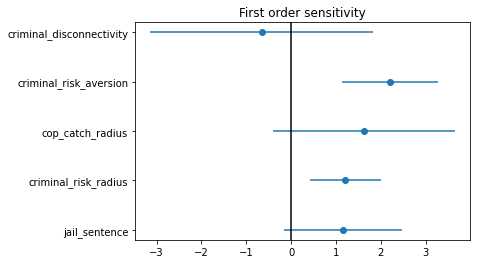

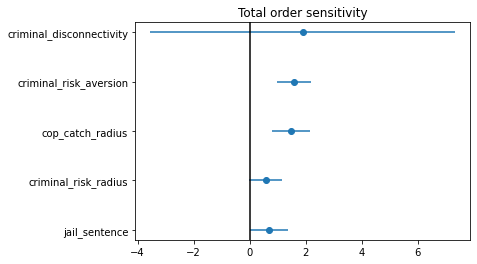

{'S1': array([ 0.33997278,  0.23114102,  0.26044635, -0.26070526, -0.87083582]), 'S1_conf': array([1.74129546, 2.1675783 , 1.08914835, 3.11326315, 3.96396872]), 'ST': array([1.06384703, 1.21045095, 0.38155501, 3.82123898, 0.67842256]), 'ST_conf': array([1.39517452, 1.39641139, 0.44480884, 5.90233228, 2.6845141 ])}


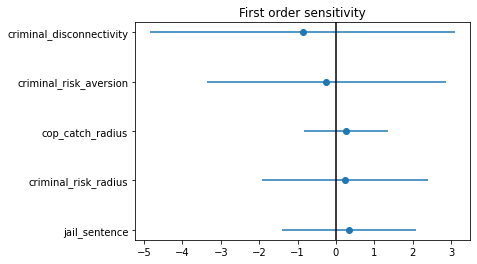

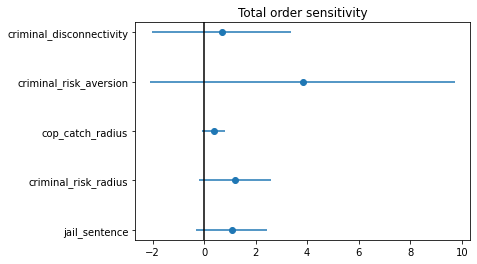

{'S1': array([ 1.12851259,  1.77436437, -0.04954589,  0.33871654,  0.7522548 ]), 'S1_conf': array([ 2.16802099,  5.34587133, 42.45035139,  7.96382908,  8.90528724]), 'ST': array([ 0.9808126 ,  2.64160965, 16.4827995 ,  3.14288208,  2.47849522]), 'ST_conf': array([  2.10914922,  14.06374507, 556.17303543,  34.46845425,
        33.34035996])}


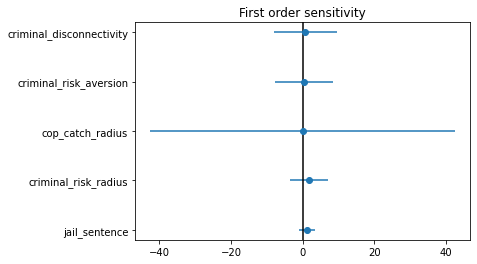

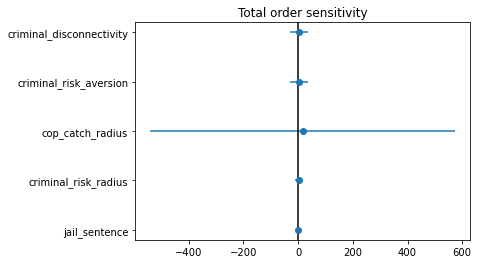

{'S1': array([ 0.01309796, -0.46759029, -2.43022297, -0.86940977, -0.4112048 ]), 'S1_conf': array([1.68440316, 1.10039521, 4.06430255, 4.28211331, 1.76299474]), 'ST': array([0.16598737, 0.22925825, 2.82360379, 0.96004047, 0.24896727]), 'ST_conf': array([0.32111974, 0.35790363, 5.0023912 , 3.6750751 , 0.68933126])}


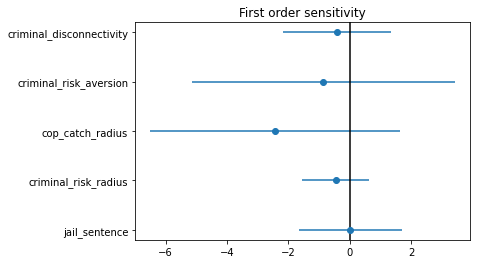

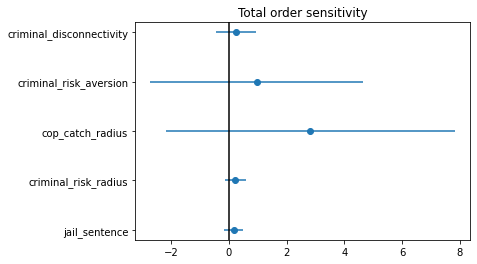

{'S1': array([-0.96906387, -0.41836481, -0.69047285, -1.86904733, -0.84347105]), 'S1_conf': array([1.10606325e+31, 4.59985798e+30, 5.07354273e+30, 2.05649208e+31,
       3.88958579e+30]), 'ST': array([1.21837042, 0.50633029, 0.31845529, 5.16973482, 0.3885342 ]), 'ST_conf': array([1.20939023e+31, 2.09168063e+30, 2.54465655e+30, 4.18081173e+31,
       1.49559237e+30])}


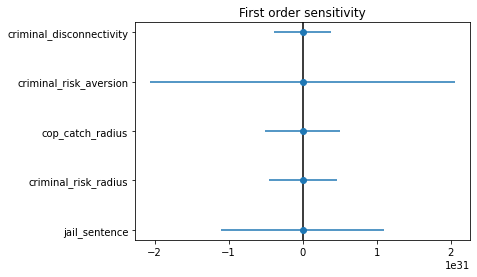

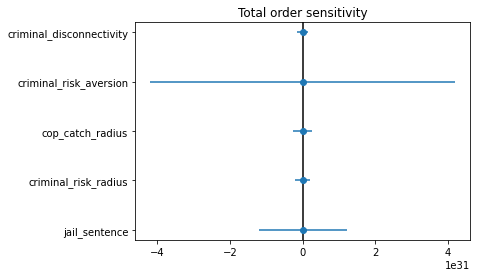

{'S1': array([-0.71635612, -0.22714047, -0.41208033, -0.25703128, -0.36254215]), 'S1_conf': array([3.91200954, 2.41641128, 4.60216179, 7.06759445, 1.90488477]), 'ST': array([0.54150289, 0.30048564, 1.58761068, 0.84115786, 0.08799826]), 'ST_conf': array([ 5.35070725,  2.46167725,  9.63198558, 11.09299407,  0.42313169])}


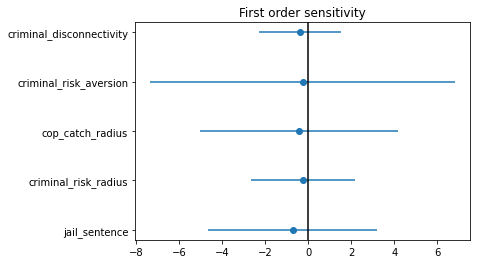

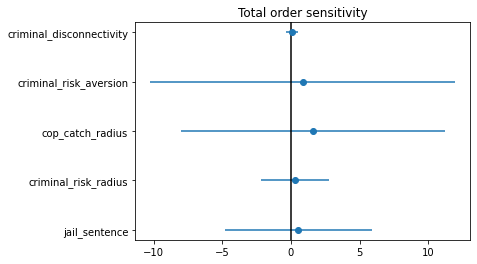

{'S1': array([ 0.32457492,  0.25911339,  0.03002196, -0.12680027, -0.84660225]), 'S1_conf': array([0.45176854, 0.69053316, 0.59665599, 2.4210378 , 0.77783377]), 'ST': array([0.64360557, 0.26936894, 0.24708142, 1.55567262, 0.41593679]), 'ST_conf': array([1.9538752 , 0.55175685, 0.59365749, 5.13000011, 0.47808193])}


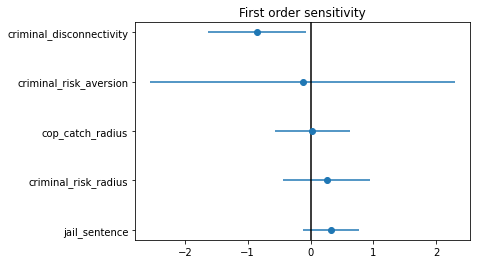

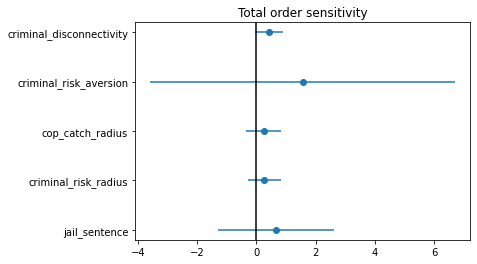

In [15]:
for Si in (Si_crimes, Si_jail, Si_centrum, Si_noord, Si_west, Si_zuid, Si_zuidoost, Si_oost, Si_nieuw_west):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Run model

In [16]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

## Criminal disconnectivity experiment

In [17]:
num_runs = 50
outputs = []
output_dict = {}

criminal_disconnectivities = [0,25,75,100]

for val in criminal_disconnectivities:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_disconnectivity=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict:
            output_dict[val].append(output)
        else:
            output_dict[val] = [output]
        #outputs.append(output)

Run 2/2 of value 0


No handles with labels found to put in legend.


Criminal disconnectivity 0


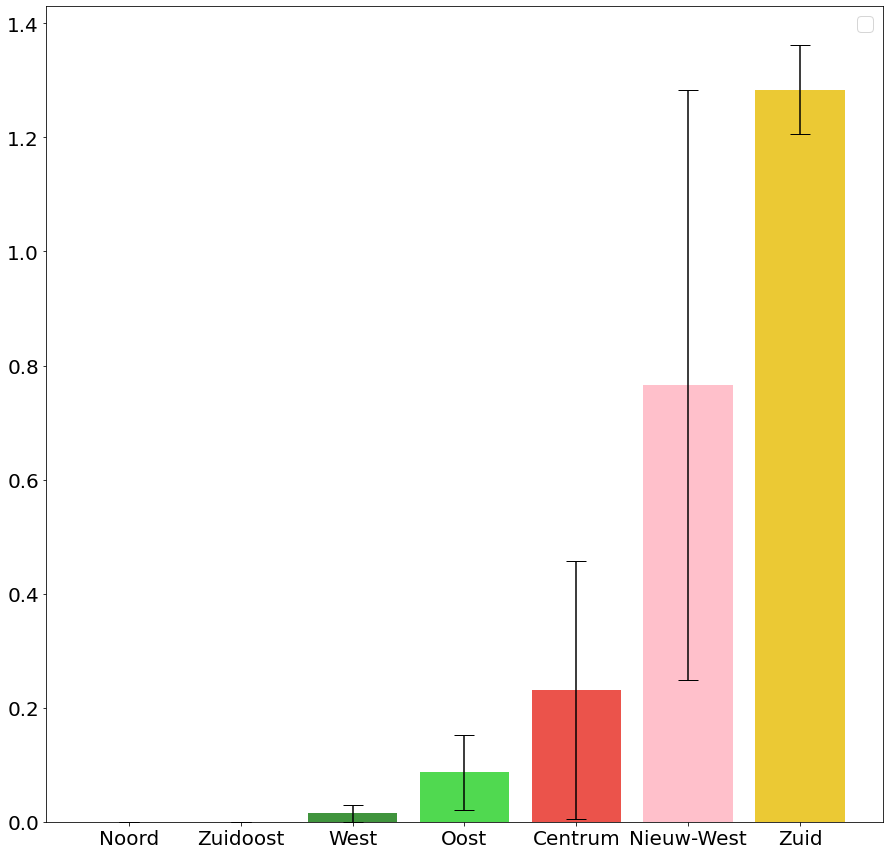

No handles with labels found to put in legend.


Criminal disconnectivity 15


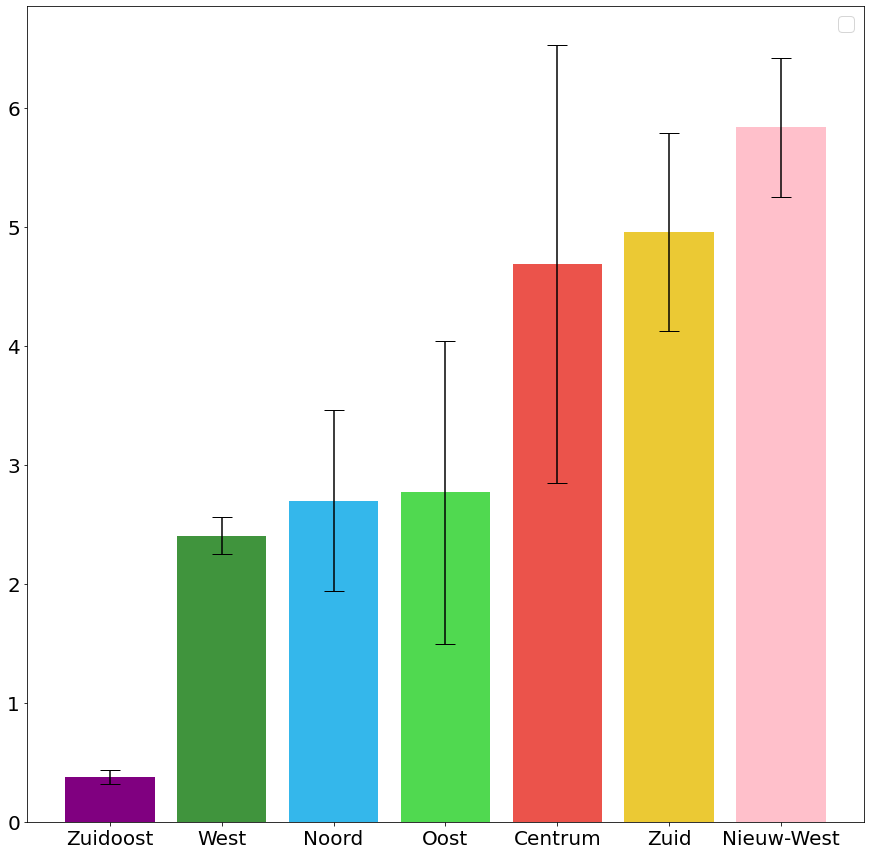

No handles with labels found to put in legend.


Criminal disconnectivity 30


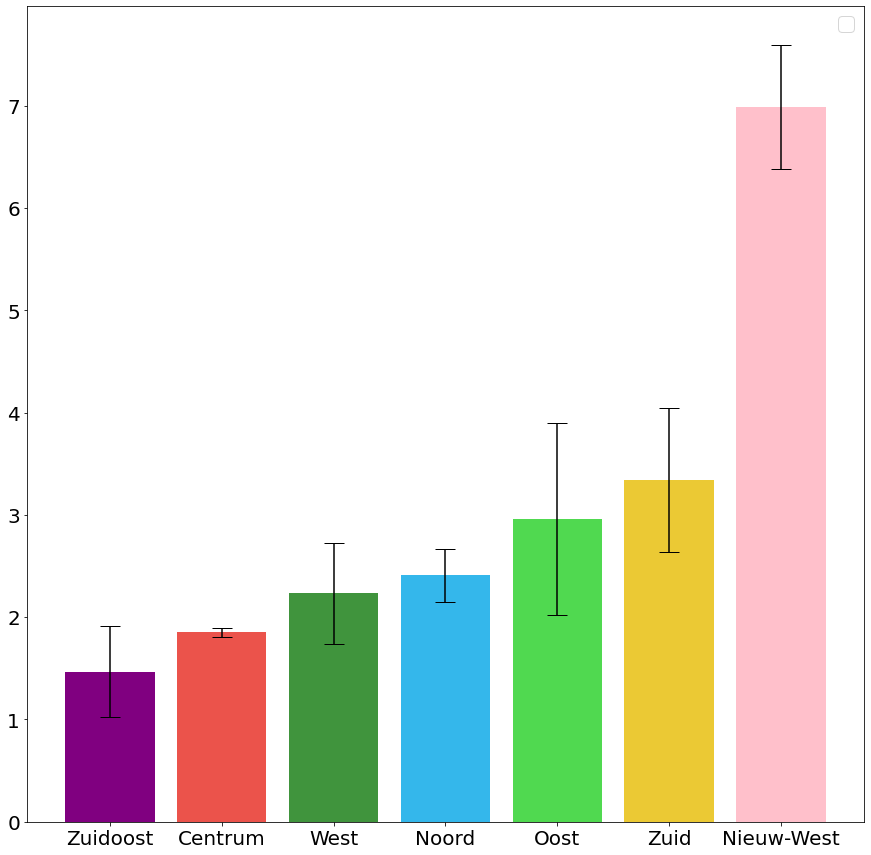

No handles with labels found to put in legend.


Criminal disconnectivity 45


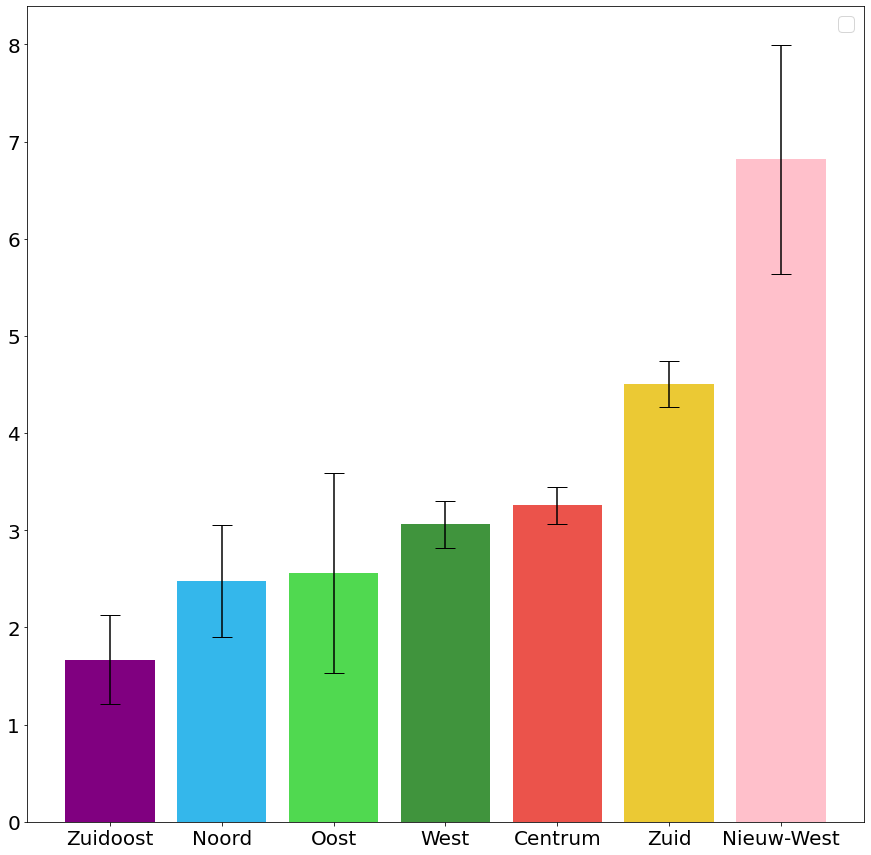

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict:
    avg_crimes_per_distr_dict_cd, confidence_bounds = get_average_crime_per_distr(output_dict[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_cd.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal disconnectivity {keys}")
    plot_district_means_bar(avg_crimes_per_distr_dict_cd, district_colors,confidence_bounds,f"criminaldisconnectivity_{keys}_")

## Criminal risk aversion

In [ ]:
num_runs = 50
output_dict_ra = {}

criminal_risk_aversions = [0, 10, 100, 500]

for val in criminal_risk_aversions:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_risk_aversion=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_ra:
            output_dict_ra[val].append(output)
        else:
            output_dict_ra[val] = [output]
        #outputs.append(output)

Run 3 of value 100


No handles with labels found to put in legend.


Criminal risk aversion 0


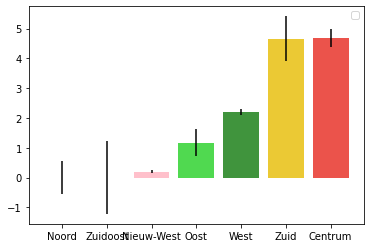

Criminal risk aversion 10


No handles with labels found to put in legend.


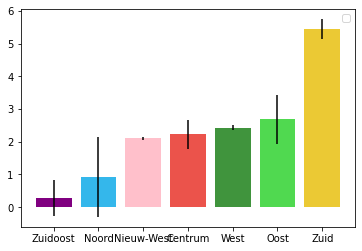

No handles with labels found to put in legend.


Criminal risk aversion 100


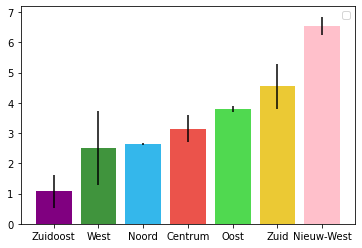

No handles with labels found to put in legend.


Criminal risk aversion 500


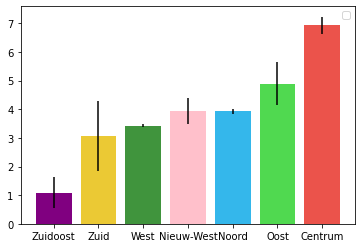

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_ra:
    avg_crimes_per_distr_dict_ra, confidence_bounds_ra = get_average_crime_per_distr(output_dict_ra[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_ra.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal risk aversion {keys}")
    plot_district_means_bar(avg_crimes_per_distr_dict_ra, district_colors,confidence_bounds_ra, f"riskaversion_{keys}_")

In [ ]:
print(np.mean(outputs[1]["Zuid"]), np.mean(outputs[1]["Centrum"]))

4.497512437810945 1.0945273631840795


## Jail sentence

In [ ]:
num_runs = 50
output_dict_jt = {}

jail_sentences = [0, 5, 10, 20]

for val in jail_sentences:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(jail_sentence=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_jt:
            output_dict_jt[val].append(output)
        else:
            output_dict_jt[val] = [output]
        #outputs.append(output)

Run 3 of value 100


No handles with labels found to put in legend.


Criminal risk aversion 0


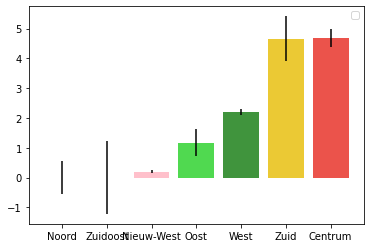

Criminal risk aversion 10


No handles with labels found to put in legend.


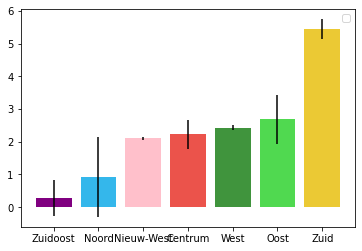

No handles with labels found to put in legend.


Criminal risk aversion 100


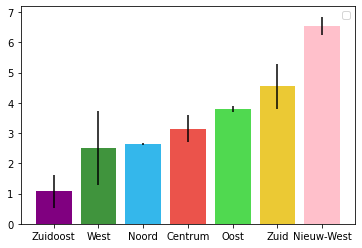

No handles with labels found to put in legend.


Criminal risk aversion 500


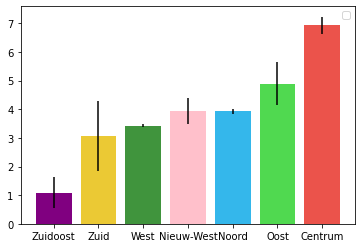

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_jt:
    avg_crimes_per_distr_dict_jt, confidence_bounds_jt = get_average_crime_per_distr(output_dict_jt[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_jt.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Jail sentence {keys}")
    plot_district_means_bar(avg_crimes_per_distr_dict_jt, district_colors,confidence_bounds_jt, f"jailsentence_{keys}_")

## Criminal Risk Radius

In [ ]:
num_runs = 50
output_dict_crr = {}

criminal_risk_radiuses = [1, 2, 5, 10]

for val in criminal_risk_radiuses:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_risk_radius=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_crr:
            output_dict_crr[val].append(output)
        else:
            output_dict_crr[val] = [output]
        #outputs.append(output)

Run 3 of value 100


No handles with labels found to put in legend.


Criminal risk aversion 0


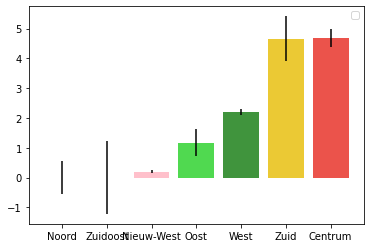

Criminal risk aversion 10


No handles with labels found to put in legend.


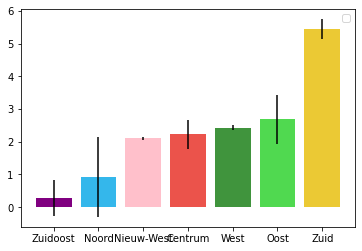

No handles with labels found to put in legend.


Criminal risk aversion 100


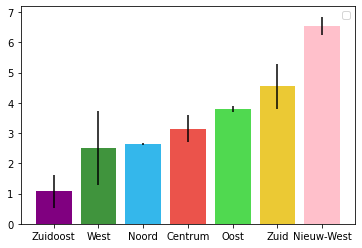

No handles with labels found to put in legend.


Criminal risk aversion 500


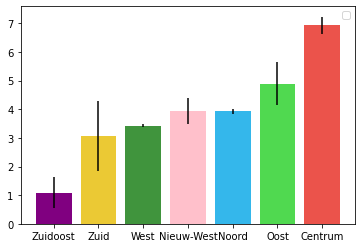

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_crr:
    avg_crimes_per_distr_dict_crr, confidence_bounds_crr = get_average_crime_per_distr(output_dict_crr[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_crr.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal Risk Radius {keys}")
    plot_district_means_bar(avg_crimes_per_distr_dict_crr, district_colors,confidence_bounds_crr, f"criminalriskradius_{keys}_")

## Cop Catch Radius

In [ ]:
num_runs = 50
output_dict_cocr = {}

cop_catch_radiuses = [1, 2, 5, 10]

for val in cop_catch_radiuses:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(cop_catch_radius=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_cocr:
            output_dict_cocr[val].append(output)
        else:
            output_dict_cocr[val] = [output]
        #outputs.append(output)

Run 3 of value 100


No handles with labels found to put in legend.


Criminal risk aversion 0


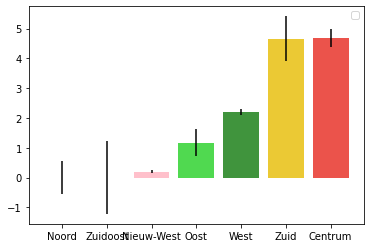

Criminal risk aversion 10


No handles with labels found to put in legend.


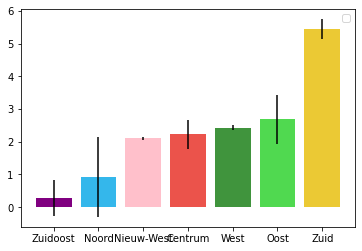

No handles with labels found to put in legend.


Criminal risk aversion 100


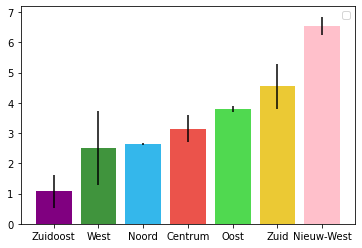

No handles with labels found to put in legend.


Criminal risk aversion 500


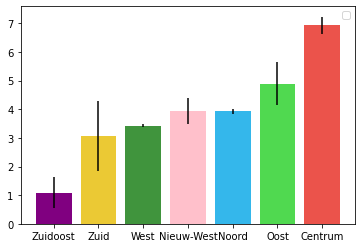

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_cocr:
    avg_crimes_per_distr_dict_cocr, confidence_bounds_cocr = get_average_crime_per_distr(output_dict_cocr[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_cocr.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Cop Catch Radius {keys}")
    plot_district_means_bar(avg_crimes_per_distr_dict_cocr, district_colors,confidence_bounds_cocr, f"copcatchradius_{keys}_")

## Plots

### Criminal wealths

In [ ]:
all_wealths = get_data(outputs, 'Criminal Wealth')

# print(all_wealths[0])
print(all_wealths.shape)

(201, 2)


In [ ]:
mean_wealths, cis_wealths = get_means_cis(all_wealths)

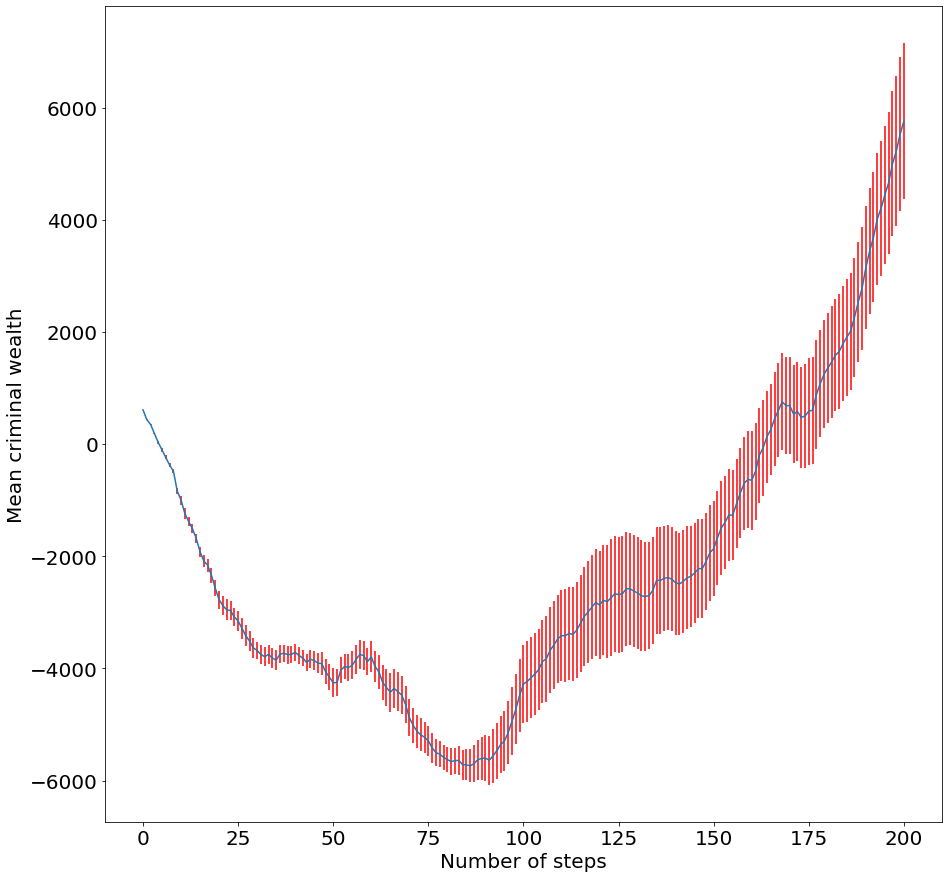

In [ ]:
plot_errorbars(mean_wealths, cis_wealths, "Mean criminal wealth")

### Criminals in jail

In [ ]:
jail_count = get_data(outputs, 'Criminal in Jail Count')

print(jail_count.shape)

(201, 2)


In [ ]:
mean_jail_count, cis_jail_count = get_means_cis(jail_count)

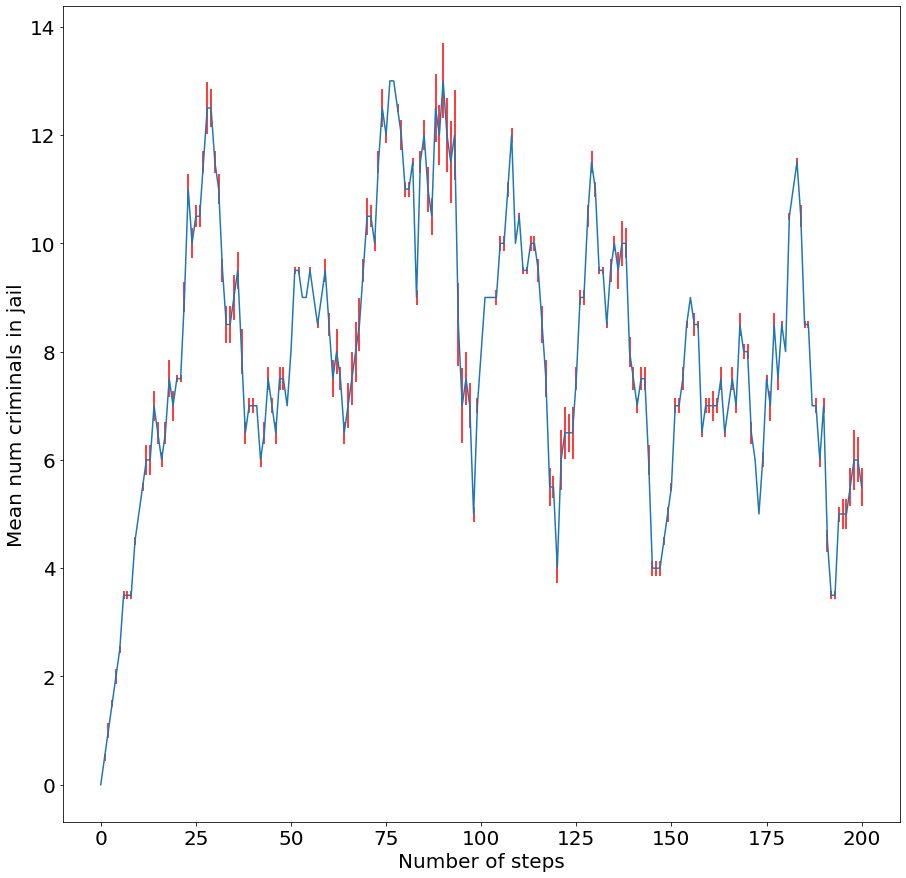

In [ ]:
plot_errorbars(mean_jail_count, cis_jail_count, "Mean num criminals in jail")

### Crimes committed

In [ ]:
crimes_count = get_data(outputs, 'Crimes commited')

print(crimes_count.shape)

(201, 2)


In [ ]:
mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)

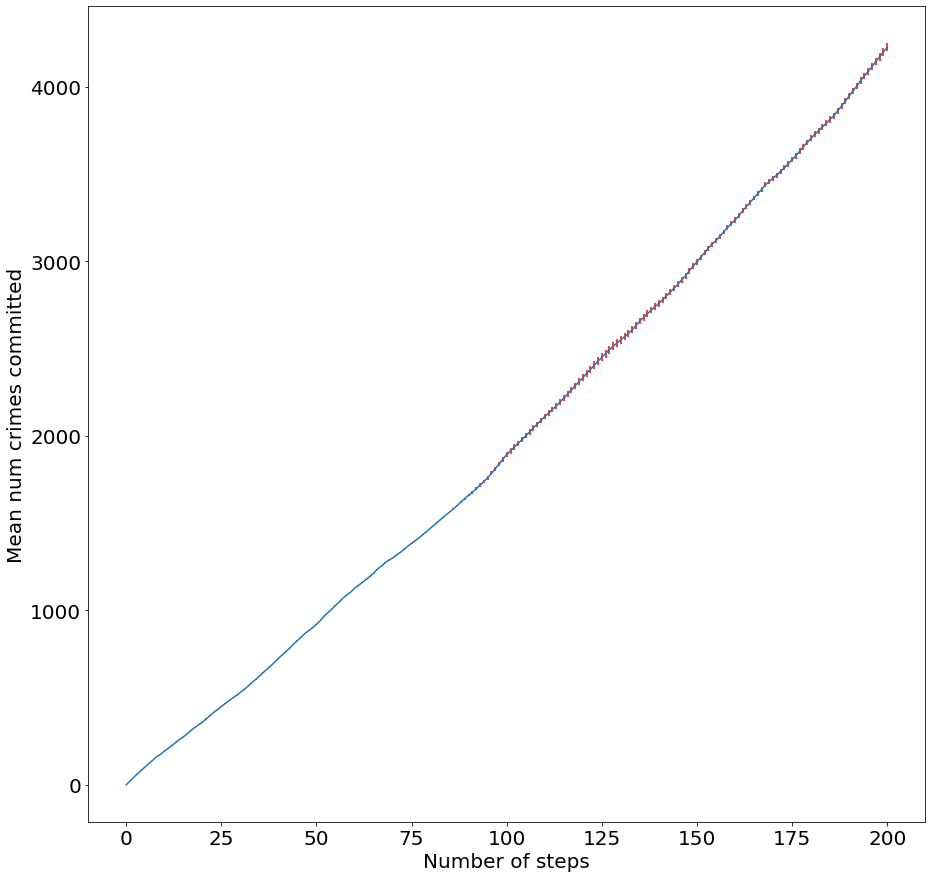

In [ ]:
plot_errorbars(mean_crimes_count, cis_crimes_count, "Mean num crimes committed")

### District crimes

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

avg_crimes_per_distr_dict, confidence_bounds = get_average_crime_per_distr(outputs, district_names, 100)

# Sort colors
district_colors = []
for district in avg_crimes_per_distr_dict.keys():
    print(district)
    for dictionary in districts_dict:
        if dictionary['Label'] == district:
            district_colors.append(dictionary['Color'])

plot_district_means_bar(avg_crimes_per_distr_dict, district_colors, confidence_bounds)

NameError: name 'get_average_crime_per_distr' is not defined

In [ ]:
all_district_means = []
all_district_cis = []

for district in district_names:
    crimes_count = get_data(outputs, district)
    mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)
    all_district_means.append(mean_crimes_count)
    all_district_cis.append(cis_crimes_count)

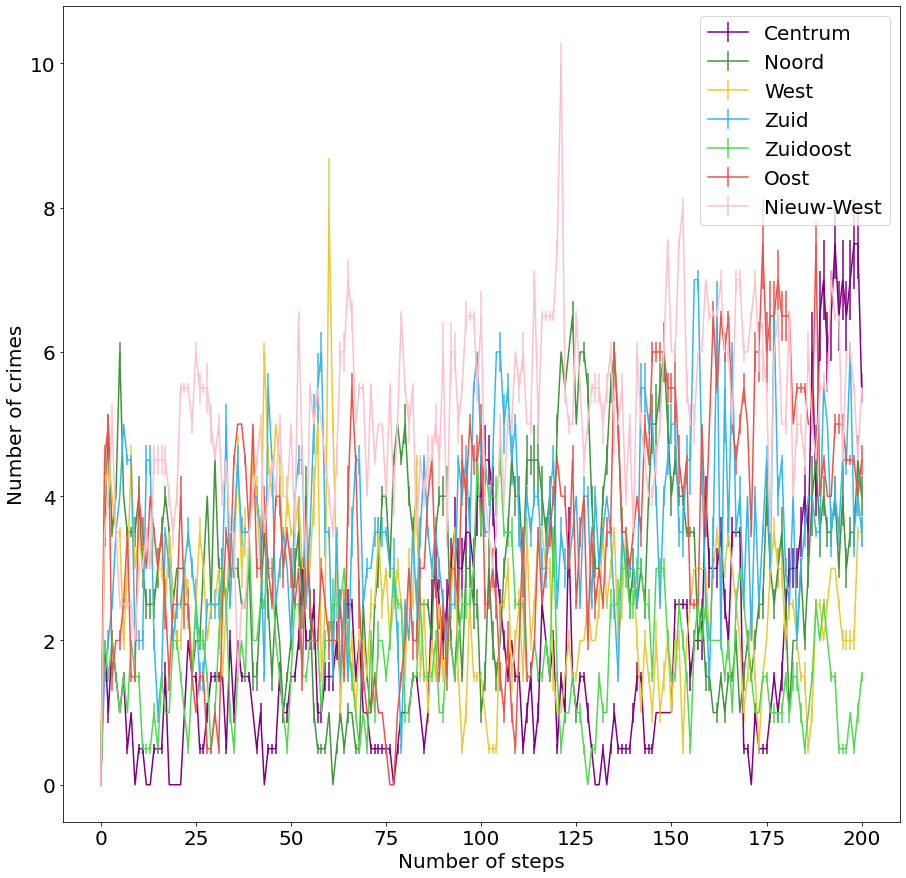

In [ ]:
plot_district_crimes(all_district_means, all_district_cis, district_names, district_colors)

In [ ]:
# print(len(all_district_means))
# print(len(all_district_means[0]))

# final_district_means = []
# for district in all_district_means:
#     final_district_means.append(district[-1])

# print(final_district_means)

# final_district_cis = []
# for district in all_district_cis:
#     final_district_cis.append(district[-1])

# print(final_district_cis)

In [ ]:
# # Sort by size
# sorting = zip(final_district_means, district_names, district_colors)
# final_district_means, district_names, district_colors = zip(*sorted(sorting, key=lambda x : x[0]))

In [ ]:
# plot_district_crimes_bar(final_district_means, final_district_cis, district_names, district_colors)